In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

import lightgbm
# import catboost
# import xgboost 

from sklearn.metrics import (classification_report, 
                             confusion_matrix, 
                             ConfusionMatrixDisplay, 
                             plot_confusion_matrix, 
                             roc_auc_score,
                             f1_score,
                             matthews_corrcoef,
                             cohen_kappa_score)

from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

RANDOM_STATE = 42

Mounted at /content/drive


In [ ]:
path = 'drive/MyDrive/UNSW Data Science/Term 3 2022/DATA3001/transformed.csv'
df = pd.read_csv(path)
df

,mean,std,max,min,nonzero_p,target
0,0.000000,0.000000,0,0,0.000000,FromInternetTCPPort554IPurn:ietf:params:mud:co...
1,0.000000,0.000000,0,0,0.000000,FromInternetTCPPort554IPurn:ietf:params:mud:co...
2,0.000000,0.000000,0,0,0.000000,FromInternetTCPPort80IPurn:ietf:params:mud:con...
3,0.000000,0.000000,0,0,0.000000,FromInternetTCPPort80IPurn:ietf:params:mud:con...
4,360.000000,611.882342,1400,0,0.257143,FromInternetUDPPort67IPurn:ietf:params:mud:con...
...,...,...,...,...,...,...
36391,0.000000,0.000000,0,0,0.000000,ToInternetUDPPort1024IPurn:ietf:params:mud:con...
36392,0.000000,0.000000,0,0,0.000000,ToLocalUDPPort5353IP224.0.0.251/32ByteCount
36393,0.000000,0.000000,0,0,0.000000,ToLocalUDPPort5353IP224.0.0.251/32PacketCount
36394,188.750000,367.941487,906,0,0.208333,ToLocalUDPPort67IP255.255.255.255/32ByteCount


In [ ]:
labels_to_drop = ['ToLocalUDPPort5353IP224.0.0.251/32ByteCount', 
                  'ToLocalUDPPort5353IP224.0.0.251/32PacketCount']

c1 = (df.target.isin(labels_to_drop))
c2 = (df.nonzero_p == 0)
df = df.loc[~(c1 | c2)].copy()

In [ ]:
# print(df.target.value_counts())

In [ ]:
def evaluate_classifier(clf, X, y):
    """Classification Metrics"""
    y_pred = clf.predict(X)
    probabilities = clf.predict_proba(X)

    roc_auc = roc_auc_score(y, probabilities, average='weighted', multi_class='ovr')
    f1score = f1_score(y, y_pred, average='weighted')

    print(f'ROC-AUC (One vs Rest) = {roc_auc}')
    print(f'Weighted F1-score = {f1score}')
    print(classification_report(y, y_pred))

In [ ]:
# Split data immediately

feature_matrix = df.drop(columns='target')
response_vector = df['target']

X_train, X_test, y_train, y_test = train_test_split(feature_matrix, 
                                                    response_vector,
                                                    random_state=RANDOM_STATE, 
                                                    test_size=0.25, 
                                                    stratify=response_vector)

## Logistic Regression

In the multiclass case, the training algorithm uses the one-vs-rest (OvR) scheme if the ‘multi_class’ option is set to ‘ovr’, and uses the cross-entropy loss if the ‘multi_class’ option is set to ‘multinomial’. (Currently the ‘multinomial’ option is supported only by the ‘lbfgs’, ‘sag’, ‘saga’ and ‘newton-cg’ solvers.)

In [ ]:
scaler = StandardScaler()
logreg = LogisticRegression(random_state=RANDOM_STATE, max_iter=5000)

pipe = Pipeline(steps=[('scaler', scaler), ('logreg', logreg)])

params_lr = {
    'logreg__multi_class': ['auto', 'ovr', 'multinomial'],
}

search_lr = GridSearchCV(estimator=pipe, param_grid=params_lr, cv=5, scoring='f1_weighted', verbose=2)
search_lr.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ...........................logreg__multi_class=auto; total time=   8.4s
[CV] END ...........................logreg__multi_class=auto; total time=   8.7s
[CV] END ...........................logreg__multi_class=auto; total time=   6.1s
[CV] END ...........................logreg__multi_class=auto; total time=   4.4s
[CV] END ...........................logreg__multi_class=auto; total time=   4.1s
[CV] END ............................logreg__multi_class=ovr; total time=   0.7s
[CV] END ............................logreg__multi_class=ovr; total time=   0.7s
[CV] END ............................logreg__multi_class=ovr; total time=   0.8s
[CV] END ............................logreg__multi_class=ovr; total time=   0.7s
[CV] END ............................logreg__multi_class=ovr; total time=   0.8s
[CV] END ....................logreg__multi_class=multinomial; total time=   4.2s
[CV] END ....................logreg__multi_class=

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('logreg',
                                        LogisticRegression(max_iter=5000,
                                                           random_state=42))]),
             param_grid={'logreg__multi_class': ['auto', 'ovr', 'multinomial']},
             scoring='f1_weighted', verbose=2)

### Grid Search Results

In [ ]:
print(search_lr.best_params_)
pd.DataFrame(search_lr.cv_results_)

{'logreg__multi_class': 'auto'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logreg__multi_class,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,6.297795,1.897895,0.045744,0.025158,auto,{'logreg__multi_class': 'auto'},0.170471,0.223896,0.191749,0.177161,0.188789,0.190413,0.018433,1
1,0.711139,0.020805,0.025322,0.000397,ovr,{'logreg__multi_class': 'ovr'},0.161848,0.207767,0.170026,0.176297,0.164577,0.176103,0.016587,3
2,4.254221,0.183444,0.026021,0.002040,multinomial,{'logreg__multi_class': 'multinomial'},0.170471,0.223896,0.191749,0.177161,0.188789,0.190413,0.018433,1


## Evaluating Logistic Regression

https://towardsdatascience.com/comprehensive-guide-on-multiclass-classification-metrics-af94cfb83fbd

"First, a multiclass problem is broken down into a series of binary problems using either One-vs-One (OVO) or One-vs-Rest (OVR, also called One-vs-All) approaches. OVO presents computational drawbacks, so professionals prefer the OVR approach. As I discussed the differences between these two approaches at length in my last article, we will only focus on OVR today."

In [ ]:
evaluate_classifier(search_lr.best_estimator_, X_test, y_test)

ROC-AUC (One vs Rest) = 0.8745998564044741
Weighted F1-score = 0.25979093840596357
                                                                   precision    recall  f1-score   support

  FromInternetTCPPort554IPurn:ietf:params:mud:controllerByteCount       1.00      0.06      0.12       127
FromInternetTCPPort554IPurn:ietf:params:mud:controllerPacketCount       0.00      0.00      0.00       127
   FromInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount       0.67      0.01      0.01       327
 FromInternetTCPPort80IPurn:ietf:params:mud:controllerPacketCount       1.00      0.00      0.01       327
   FromInternetUDPPort67IPurn:ietf:params:mud:controllerByteCount       0.63      0.02      0.05       505
 FromInternetUDPPort67IPurn:ietf:params:mud:controllerPacketCount       0.25      0.46      0.32       505
   ToInternetRSVPPortAllIPurn:ietf:params:mud:controllerByteCount       0.00      0.00      0.00       505
 ToInternetRSVPPortAllIPurn:ietf:params:mud:controllerPacket

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
search_lr.best_estimator_.score(X_test, y_test)

0.3421153846153846

## K Nearest Neighbours

In [ ]:
scaler = StandardScaler()
knn = KNeighborsClassifier()

pipeline_knn = Pipeline(steps=[('scaling_knn', scaler), ('modeling_knn', knn)])
params_knn = {'modeling_knn__n_neighbors': np.arange(3, int(np.ceil(np.sqrt(len(y_train)))), 2)}

knn_search = GridSearchCV(pipeline_knn, param_grid=params_knn, cv=5, scoring='f1_weighted', verbose=2)
knn_search.fit(X_train, y_train)

Fitting 5 folds for each of 61 candidates, totalling 305 fits
[CV] END ........................modeling_knn__n_neighbors=3; total time=   0.3s
[CV] END ........................modeling_knn__n_neighbors=3; total time=   0.3s
[CV] END ........................modeling_knn__n_neighbors=3; total time=   0.2s
[CV] END ........................modeling_knn__n_neighbors=3; total time=   0.1s
[CV] END ........................modeling_knn__n_neighbors=3; total time=   0.1s
[CV] END ........................modeling_knn__n_neighbors=5; total time=   0.1s
[CV] END ........................modeling_knn__n_neighbors=5; total time=   0.1s
[CV] END ........................modeling_knn__n_neighbors=5; total time=   0.1s
[CV] END ........................modeling_knn__n_neighbors=5; total time=   0.1s
[CV] END ........................modeling_knn__n_neighbors=5; total time=   0.1s
[CV] END ........................modeling_knn__n_neighbors=7; total time=   0.1s
[CV] END ........................modeling_knn__

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaling_knn', StandardScaler()),
                                       ('modeling_knn',
                                        KNeighborsClassifier())]),
             param_grid={'modeling_knn__n_neighbors': array([  3,   5,   7,   9,  11,  13,  15,  17,  19,  21,  23,  25,  27,
        29,  31,  33,  35,  37,  39,  41,  43,  45,  47,  49,  51,  53,
        55,  57,  59,  61,  63,  65,  67,  69,  71,  73,  75,  77,  79,
        81,  83,  85,  87,  89,  91,  93,  95,  97,  99, 101, 103, 105,
       107, 109, 111, 113, 115, 117, 119, 121, 123])},
             scoring='f1_weighted', verbose=2)

In [ ]:
print(knn_search.best_params_)
pd.DataFrame(knn_search.cv_results_)

{'modeling_knn__n_neighbors': 3}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_modeling_knn__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.040114,0.022977,0.170778,0.073543,3,{'modeling_knn__n_neighbors': 3},0.955803,0.962355,0.955294,0.959647,0.956689,0.957957,0.002666,1
1,0.023802,0.002196,0.091781,0.010528,5,{'modeling_knn__n_neighbors': 5},0.949690,0.954388,0.947252,0.949027,0.947941,0.949660,0.002510,2
2,0.024791,0.003295,0.098638,0.016577,7,{'modeling_knn__n_neighbors': 7},0.941385,0.945435,0.940813,0.941928,0.937352,0.941383,0.002580,3
3,0.021541,0.000674,0.092420,0.006731,9,{'modeling_knn__n_neighbors': 9},0.936887,0.945147,0.937420,0.939352,0.936103,0.938982,0.003264,4
4,0.021940,0.001630,0.100997,0.008384,11,{'modeling_knn__n_neighbors': 11},0.933395,0.940469,0.938325,0.936819,0.931501,0.936102,0.003256,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,0.031857,0.000792,0.232180,0.006725,115,{'modeling_knn__n_neighbors': 115},0.770728,0.769469,0.775875,0.763243,0.765391,0.768941,0.004396,57
57,0.021170,0.000806,0.154345,0.004466,117,{'modeling_knn__n_neighbors': 117},0.774660,0.767085,0.777166,0.762653,0.757512,0.767815,0.007316,58
58,0.021473,0.000881,0.152888,0.002399,119,{'modeling_knn__n_neighbors': 119},0.768989,0.759025,0.771867,0.754475,0.746928,0.760257,0.009205,59
59,0.022046,0.000756,0.156534,0.003049,121,{'modeling_knn__n_neighbors': 121},0.765742,0.753745,0.767672,0.753951,0.745285,0.757279,0.008331,60


In [ ]:
evaluate_classifier(knn_search.best_estimator_, X_test, y_test)

ROC-AUC (One vs Rest) = 0.9934980725336638
Weighted F1-score = 0.9686756978316733
                                                                   precision    recall  f1-score   support

  FromInternetTCPPort554IPurn:ietf:params:mud:controllerByteCount       0.97      0.96      0.96       127
FromInternetTCPPort554IPurn:ietf:params:mud:controllerPacketCount       0.86      0.91      0.88       127
   FromInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount       0.97      0.97      0.97       327
 FromInternetTCPPort80IPurn:ietf:params:mud:controllerPacketCount       0.94      0.98      0.96       327
   FromInternetUDPPort67IPurn:ietf:params:mud:controllerByteCount       0.96      0.97      0.97       505
 FromInternetUDPPort67IPurn:ietf:params:mud:controllerPacketCount       0.97      0.97      0.97       505
   ToInternetRSVPPortAllIPurn:ietf:params:mud:controllerByteCount       0.99      0.99      0.99       505
 ToInternetRSVPPortAllIPurn:ietf:params:mud:controllerPacketC

## Random Forest

In [ ]:
params_rf = {
    'n_estimators':np.arange(100, 501, 50),
    'max_depth': np.arange(3, 17, 1),
    'min_samples_leaf': np.arange(3, 31, 2),
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestClassifier(random_state=RANDOM_STATE)

search_rf = RandomizedSearchCV(estimator=rf, 
                               random_state=RANDOM_STATE,
                               param_distributions=params_rf, 
                               n_iter=10,
                               cv=5,
                               scoring='f1_weighted')

search_rf.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   param_distributions={'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': array([ 3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]),
                                        'n_estimators': array([100, 150, 200, 250, 300, 350, 400, 450, 500])},
                   random_state=42, scoring='f1_weighted')

https://www.baeldung.com/cs/multi-class-f1-score

In [ ]:
evaluate_classifier(search_rf.best_estimator_, X_test, y_test)

ROC-AUC (One vs Rest) = 0.9999229015142872
Weighted F1-score = 0.9892002980310827
                                                                   precision    recall  f1-score   support

  FromInternetTCPPort554IPurn:ietf:params:mud:controllerByteCount       0.99      1.00      1.00       127
FromInternetTCPPort554IPurn:ietf:params:mud:controllerPacketCount       0.98      0.94      0.96       127
   FromInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount       0.98      0.99      0.98       327
 FromInternetTCPPort80IPurn:ietf:params:mud:controllerPacketCount       0.99      0.97      0.98       327
   FromInternetUDPPort67IPurn:ietf:params:mud:controllerByteCount       1.00      1.00      1.00       505
 FromInternetUDPPort67IPurn:ietf:params:mud:controllerPacketCount       1.00      1.00      1.00       505
   ToInternetRSVPPortAllIPurn:ietf:params:mud:controllerByteCount       0.99      1.00      1.00       505
 ToInternetRSVPPortAllIPurn:ietf:params:mud:controllerPacketC

## Feature Importances

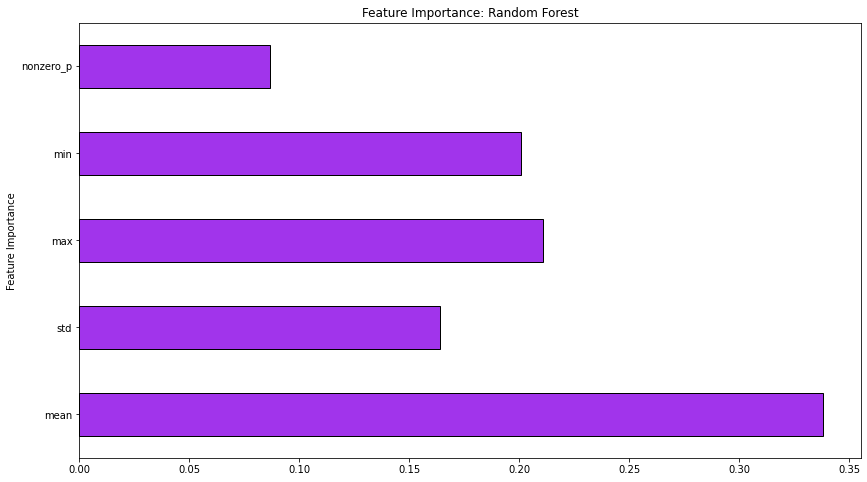

In [ ]:
forest_importances = pd.Series(search_rf.best_estimator_.feature_importances_, index=X_train.columns)

fig, ax = plt.subplots(figsize=(14, 8))

forest_importances.plot(kind='barh', 
                        ax=ax, 
                        width=0.5,
                        title='Feature Importance: Random Forest',  
                        ylabel='Feature Importance',
                        color='#a134eb', 
                        edgecolor='black');

# LightGBM

In [ ]:
params_lgbm = {
    'eta': np.linspace(0.0001, 0.3, 100),
    'n_estimators': np.arange(100, 501, 50),
    'max_depth': np.arange(3, 17, 1),
    'min_child_weight': np.arange(0, 25, 1),
    'subsample': np.linspace(0.8, 1, 20),
    'reg_alpha': [0.0001, 0.01, 0.1, 1, 10, 100],
    'colsample_bytree': [0.75, 0.8, 0.85, 0.9, 0.95, 1]
}

# Use gradient based one side sampling as well as exclusive feature bundling

lgbm = lightgbm.LGBMClassifier(boosting='goss', 
                               enable_bundle=True, 
                               objective='multiclass', 
                               random_state=RANDOM_STATE)

search_lgbm = RandomizedSearchCV(estimator=lgbm,
                                 random_state=RANDOM_STATE,
                                 param_distributions=params_lgbm,
                                 n_iter=10,
                                 cv=5,
                                 scoring='f1_weighted')

search_lgbm.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(boosting='goss', enable_bundle=True,
                                            objective='multiclass',
                                            random_state=42),
                   param_distributions={'colsample_bytree': [0.75, 0.8, 0.85,
                                                             0.9, 0.95, 1],
                                        'eta': array([1.00000000e-04, 3.12929293e-03, 6.15858586e-03, 9.18787879e-03,
       1.22171717e-02, 1.52464646e-02, 1.82757576e-02, 2.13050505e-02,
       2.43343434e-02, 2.73636364e...
                                        'n_estimators': array([100, 150, 200, 250, 300, 350, 400, 450, 500]),
                                        'reg_alpha': [0.0001, 0.01, 0.1, 1, 10,
                                                      100],
                                        'subsample': array([0.8       , 0.81052632, 0.82105263, 0.83157895, 0.84210526,
       0.8526

In [ ]:
evaluate_classifier(search_lgbm.best_estimator_, X_test, y_test)

ROC-AUC (One vs Rest) = 0.9999484345533943
Weighted F1-score = 0.990957323290745
                                                                   precision    recall  f1-score   support

  FromInternetTCPPort554IPurn:ietf:params:mud:controllerByteCount       0.98      0.99      0.99       127
FromInternetTCPPort554IPurn:ietf:params:mud:controllerPacketCount       0.97      0.94      0.96       127
   FromInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount       0.98      0.99      0.99       327
 FromInternetTCPPort80IPurn:ietf:params:mud:controllerPacketCount       0.98      0.99      0.98       327
   FromInternetUDPPort67IPurn:ietf:params:mud:controllerByteCount       1.00      1.00      1.00       505
 FromInternetUDPPort67IPurn:ietf:params:mud:controllerPacketCount       1.00      1.00      1.00       505
   ToInternetRSVPPortAllIPurn:ietf:params:mud:controllerByteCount       1.00      1.00      1.00       505
 ToInternetRSVPPortAllIPurn:ietf:params:mud:controllerPacketCo

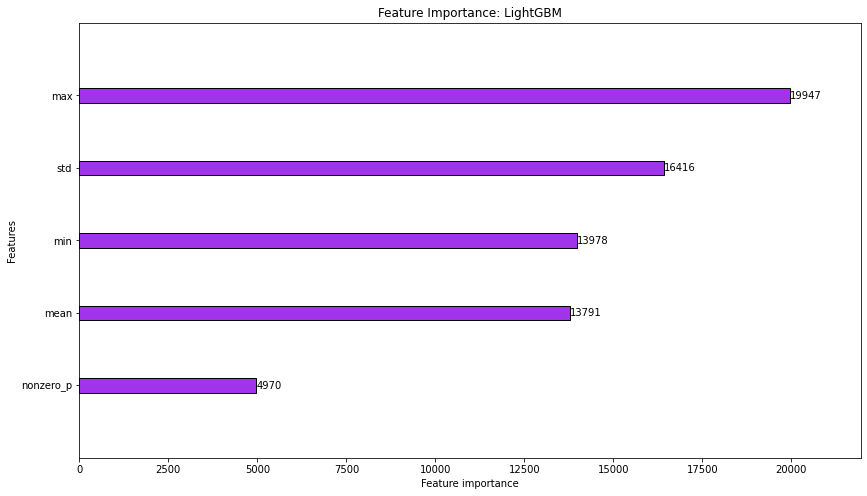

In [ ]:
lightgbm.plot_importance(search_lgbm.best_estimator_, 
                         figsize=(14, 8),
                         title='Feature Importance: LightGBM',
                         grid=False,
                         color='#a134eb', 
                         edgecolor='black');

# CatBoost

* Took so long to run when trying hyperparameter tuning that we just use the default params here

In [ ]:
# catboost_model = catboost.CatBoostClassifier(random_state=RANDOM_STATE, loss_function='MultiClass')
# catboost_model.fit(X_train, y_train)

In [ ]:
# evaluate_classifier(catboost_model, X_test, y_test)